# Purpose
The purpose of this notebook is to demonstrate the use of possterior predictive checks for checking one's discrete choice models.


## Import needed packages

In [1]:
import sys
from collections import OrderedDict

import scipy.stats
import pandas as pd
import numpy as np

import pylogit as pl

sys.path.insert(0, '../src')
from visualization import predictive_viz as viz

%matplotlib inline

## Define helper functions

In [ ]:
def unpack_on_binder(zip_file_path, temp_dir='./temp'):
    import os
    import json
    from zipfile import ZipFile
    import pandas as pd
    from collections import OrderedDict

    # Unpack the zip file to the temporary directory.
    with ZipFile(zip_file_path, 'r') as zipfile:
        zipfile.extractall(temp_dir)

    # Load the needed objects from the temporary directory
    cov_path = os.path.join(temp_dir, 'cov.csv')
    cov_df = pd.read_csv(cov_path, index_col=0)

    df_path = os.path.join(temp_dir, 'df.csv')
    df = pd.read_csv(df_path)

    param_path = os.path.join(temp_dir, 'params.csv')
    params =\
        pd.read_csv(param_path,
                    index_col=0,
                    names=['value']).iloc[:, 0]

    spec_path = os.path.join(temp_dir, 'spec.json')
    with open(spec_path, 'rb') as f:
        spec = json.load(f, object_pairs_hook=OrderedDict)
    # Convert all entries to strings
    new_spec = OrderedDict()
    for key, value in spec.items():
        new_spec[str(key)] = value

    name_path = os.path.join(temp_dir, 'names.json')
    with open(name_path, 'rb') as f:
        name_spec = json.load(f, object_pairs_hook=OrderedDict)
    # Convert all entries to strings
    new_name_spec = OrderedDict()
    for key, value in name_spec.items():
        new_name_spec[str(key)] = list(map(lambda x: str(x), value))

    # Save the alt_id_col, obs_id_col, and choice_col
    col_dict_path = os.path.join(temp_dir, 'col_dict.json')
    with open(col_dict_path, 'rb') as f:
        col_dict = json.load(f)
    # Convert all entries to strings
    new_col_dict = {str(k): str(v) for k, v in col_dict.items()}

    # Package the loaded objects into a dictionary for return
    results_dict =\
        {'cov_df': cov_df,
         'df': df,
         'param_series': params,
         'spec_dict': new_spec,
         'name_dict': new_name_spec,
         'col_dict': new_col_dict}

    # Return the created dictionary
    return results_dict

# Load one's data

In [3]:
estimation_results = unpack_on_binder('./temp.zip')

df = estimation_results['df']
estimated_params = estimation_results['param_series']
estimated_cov_df = estimation_results['cov_df']
model_col_dict = estimation_results['col_dict']

# Recreate the model object

In [4]:
# Recreate the mnl model
mnl = pl.create_choice_model(data=df,
                             alt_id_col=model_col_dict['alt_id_col'],
                             obs_id_col=model_col_dict['obs_id_col'],
                             choice_col=model_col_dict['choice_col'],
                             specification=estimation_results['spec_dict'],
                             model_type='MNL',
                             names=estimation_results['name_dict'])

/Users/tbrathwaite/anaconda2/lib/python2.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


In [ ]:
# Recreate the predicted probabilities
long_fitted_probs =\
    mnl.predict(df,
                param_list=[estimated_params.values, None, None, None])
# Set this attribute on the model object
setattr(mnl, 'long_fitted_probs', long_fitted_probs)

# MNL Model Checking

In [5]:
# Simulate values from the sampling distribution of coefficients
mnl_sampling_dist =\
    scipy.stats.multivariate_normal(mean=estimated_params.values,
                                    cov=estimated_cov_df.values)

In [6]:
# Take Draws from the sampling distribution
num_draws = 1000
np.random.seed(325)
simulated_coefs = mnl_sampling_dist.rvs(num_draws)
simulated_coefs.shape

(1000, 16)

In [7]:
# Predict the model probabilities
simulated_probs =\
    mnl.predict(df, param_list=[simulated_coefs.T, None, None, None])

# Simulate y from the sampling distribution
likelihood_sim_y =\
    viz.simulate_choice_vector(simulated_probs,
                               df[model_col_dict['obs_id_col']].values,
                               rseed=1122018)

SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnU2ltdWxhdGluZyBDaG9pY2VzJywgbWF4PTcwMjQuMCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXPigKY=


# Make the seven desired plots

In [9]:
import seaborn as sbn
import matplotlib.pyplot as plt

### 1. Predictive Performance (log-likelihood) plot

In [ ]:
reload(viz)

sim_log_likes =\
    viz.compute_prior_predictive_log_likelihoods(likelihood_sim_y,
                                                 df,
                                                 model_col_dict['choice_col'],
                                                 mnl)

current_log_likelihood =\
    np.log(long_fitted_probs).dot(mnl.choices)

viz.plot_predicted_log_likelihoods(sim_log_likes,
                                   current_log_likelihood)

### 2. Market Share Boxplot

In [ ]:
reload(viz)

airline_text_dict =\
    {1: 'american',
     2: 'continental',
     3: 'delta',
     4: 'jet_blue',
     5: 'southwest',
     6: 'united',
     7: 'us_airways',
     8: 'other'}

viz.plot_simulated_market_shares(df.airline.values,
                                 likelihood_sim_y,
                                 mnl.choices,
                                 x_label='Airline',
                                 y_label='Number\nof times\nchosen',
                                 display_dict=airline_text_dict)

In [ ]:
reload(viz)

In [ ]:
aircraft_type_dict =\
    {1: 'widebody', 2: 'standard', 3: 'regional', 4: 'propeller'}
viz.plot_simulated_market_shares(df.aircraft_type.values,
                                 likelihood_sim_y,
                                 mnl.choices,
                                 x_label='Aircraft Type',
                                 y_label='Number\nof times\nchosen',
                                 display_dict=aircraft_type_dict)

### 3. Binned Reliability Plot

In [ ]:
reload(viz)
current_airline = 4  # jet_blue
current_airline_text = airline_text_dict[current_airline]
filter_idx = np.where((df.airline == current_airline).values)[0]

# current_probs = simulated_probs[filter_idx, :]
current_probs = long_fitted_probs[filter_idx]
current_choices = mnl.choices[filter_idx]
current_sim_y = likelihood_sim_y[filter_idx, :]

current_line_label = 'Observed vs Predicted ({})'.format(current_airline_text)
current_sim_label = 'Simulated vs Predicted ({})'.format(current_airline_text)

current_sim_color = '#a6bddb'
current_obs_color = '#045a8d'

viz.plot_binned_reliability(
    current_probs,
    current_choices,
    partitions=70,
    sim_y=current_sim_y,
    line_label=current_line_label,
    line_color=current_obs_color,
    sim_label=current_sim_label,
    sim_line_color=current_sim_color,
    figsize=(10, 6),
    ref_line=True)

###  4. Binned Marginal Model Plot

In [ ]:
current_airline = 1  # american_airlines
current_airline_text = airline_text_dict[current_airline]
selection_idx = (df.airline == current_airline).values

num_traces = 200
current_probs = simulated_probs[selection_idx]
current_y = mnl.choices[selection_idx]
current_x = df.loc[selection_idx, 'performance'].values
current_sim_y = likelihood_sim_y[selection_idx]

current_y_label = 'Observed P(Y={})'.format(current_airline_text)
current_prob_label = 'Predicted P(Y={})'.format(current_airline_text)
current_sim_label = 'Simulated P(Y={})'.format(current_airline_text)
current_x_label =\
    'Binned, Mean {} Performance'.format(current_airline_text)

viz.make_binned_marginal_model_plot(current_probs,
                                    current_y,
                                    current_x,
                                    partitions=70,
                                    sim_y=current_sim_y,
                                    y_label=current_y_label,
                                    prob_label=current_prob_label,
                                    sim_label=current_sim_label,
                                    x_label=current_x_label,
                                    alpha=0.5,
                                    figsize=(10, 6))

### 5. Simulated Histogram

In [ ]:
reload(viz)

current_airline = 6  # united
current_airline_text = airline_text_dict[current_airline]

current_class = 4  # first class
class_value_to_text_dict =\
    {1: 'economy',
     2: 'premium',
     3: 'business',
     4: 'first_class'}
current_class_text = class_value_to_text_dict[current_class]

filter_row = ((df.airline == current_airline) &
              (df.classTicket == current_class))

current_title =\
    'Num Observations Flying {airline} in {class_val}'.format(
        airline=current_airline,
        class_val=class_value_to_text_dict[current_class])

viz.plot_categorical_predictive_densities(
    df,
    None,
    likelihood_sim_y,
    'classTicket',
    filter_row,
    mnl.choices,
    title=current_title,
    filter_name='observations',
    post_color=sbn.color_palette('colorblind')[0],
    figsize=(10, 6),
    legend_loc='upper left')

### 6. Simulated KDE

In [ ]:
reload(viz)
current_airline = 3  # delta
current_airline_text = airline_text_dict[current_airline]

filter_row = df.airline == current_airline

current_title = 'KDE of Fare for {}'.format(current_airline_text)

viz.plot_simulated_kde_traces(likelihood_sim_y,
                              df,
                              filter_row,
                              'price_over_log_income',
                              'choice',
                              title=current_title.format(current_fuel),
                              figsize=(10, 6),
                              label='Simulated',
                              n_traces=500,
                              output_file=filename)

### 7. Simulated CDF

Calculating CDFs: 100%|██████████| 1000/1000 [00:03<00:00, 300.83it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


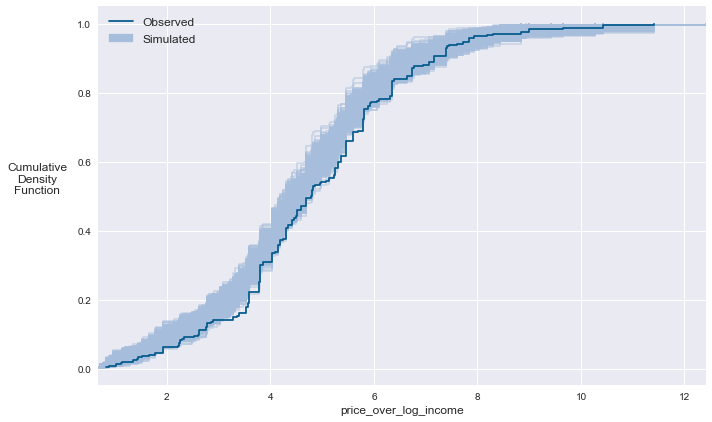

In [17]:
reload(viz)
current_body = 'sportuv'
filter_row = car_df.body_type == current_body
# current_title =\
#     'CDF of Price/log(income) for Sport Utility Vehicles'
current_title = ''
# filename =\
#     '../reports/figures/cdf-vehicle-choice-mnl-suv-price.pdf'
filename =\
    '../reports/figures/cdf-vehicle-choice-mnl-suv-price.jpeg'

viz.plot_simulated_cdf_traces(likelihood_sim_y,
                              car_df,
                              filter_row,
                              'price_over_log_income',
                              'choice',
                              label='Simulated',
                              title=current_title,
                              figsize=(10, 6),
                              output_file=filename)

## Sandbox:
Look at additional plots.

Plotting: 100%|██████████| 1000/1000 [00:03<00:00, 291.75it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1000/1000 [00:04<00:00, 249.14it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1000/1000 [00:03<00:00, 277.79it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1000/1000 [00:03<00:00, 278.92it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figur

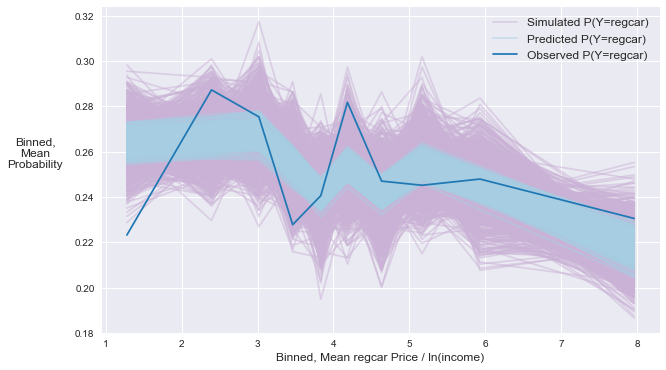

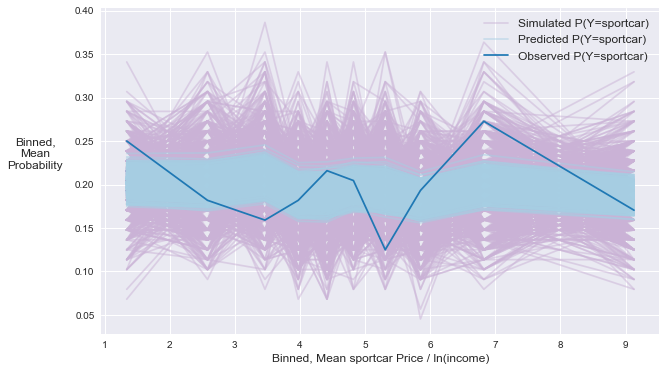

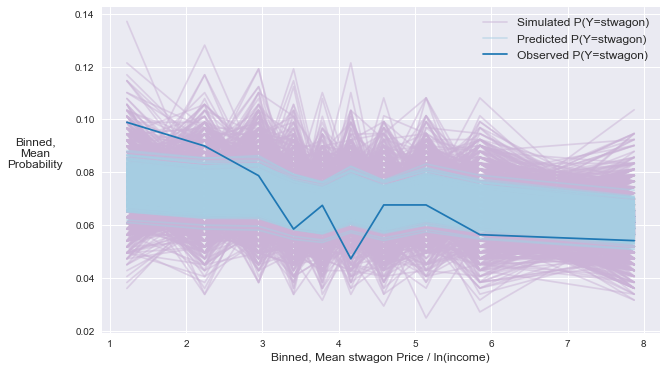

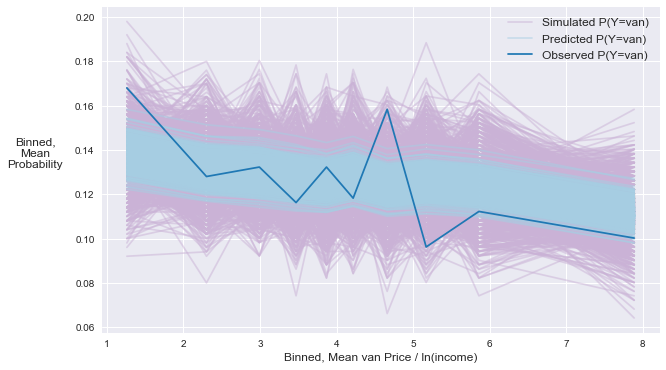

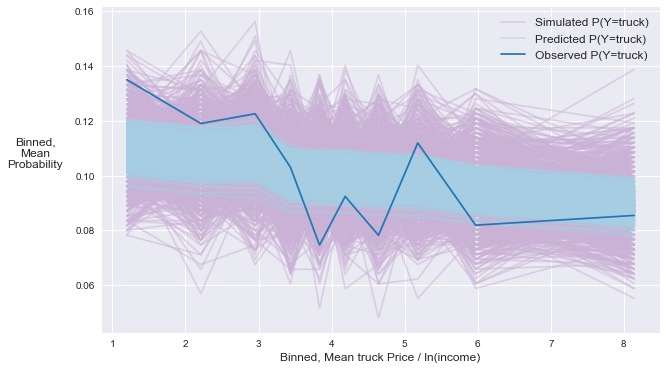

In [18]:
for body in ['regcar', 'sportcar', 'stwagon', 'van', 'truck']:
    current_body = body
    selection_idx = (car_df.body_type == current_body).values

    num_traces = 500
    current_probs = simulated_probs[selection_idx]
    current_y = car_df.loc[selection_idx, 'choice'].values
    current_x = car_df.loc[selection_idx, 'price_over_log_income'].values
    current_sim_y = likelihood_sim_y[selection_idx]

    filename = None

    viz.make_binned_marginal_model_plot(current_probs,
                                        current_y,
                                        current_x,
                                        partitions=10,
                                        sim_y=current_sim_y,
                                        y_label='Observed P(Y={})'.format(body),
                                        prob_label='Predicted P(Y={})'.format(body),
                                        sim_label='Simulated P(Y={})'.format(body),
                                        x_label='Binned, Mean {} Price / ln(income)'.format(body),
                                        alpha=0.5,
                                        figsize=(10, 6),
                                        output_file=filename)

Calculating CDFs: 100%|██████████| 1000/1000 [00:04<00:00, 240.80it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Calculating CDFs: 100%|██████████| 1000/1000 [00:04<00:00, 225.06it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Calculating CDFs: 100%|██████████| 1000/1000 [00:03<00:00, 259.78it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Calculating CDFs: 100%|██████████| 1000/1000 [00:03<00:00, 252.96it/s]
/Users/timothyb0912/anaconda/lib/python2.

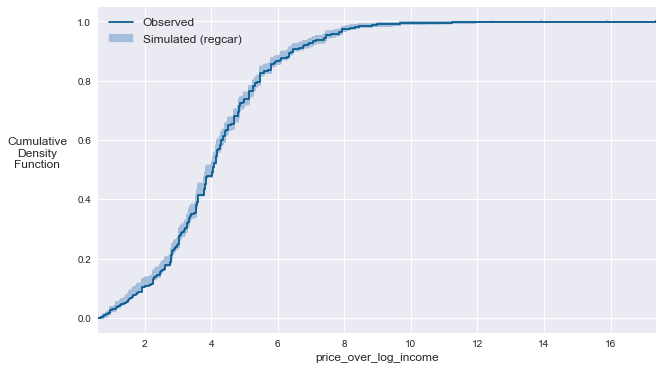

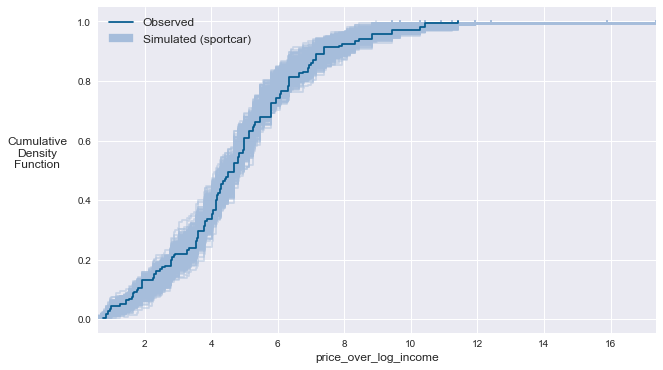

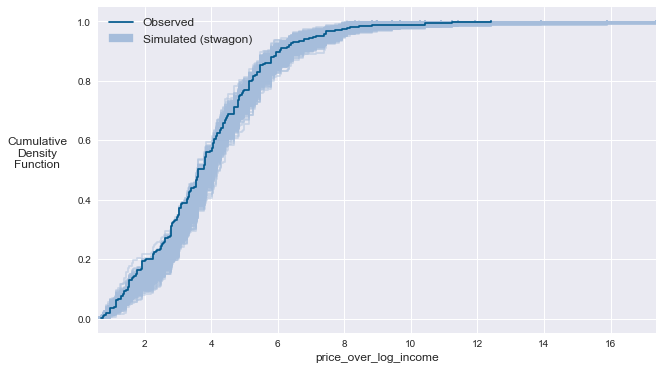

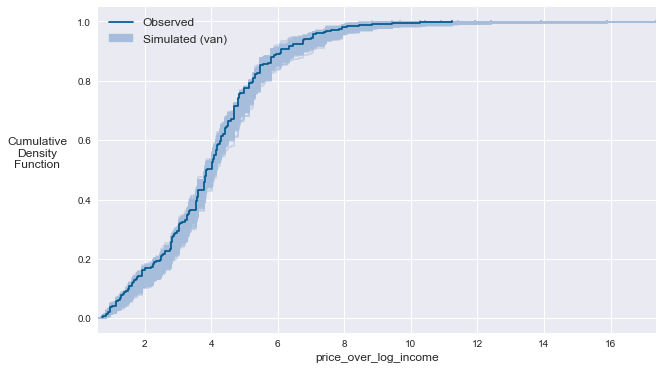

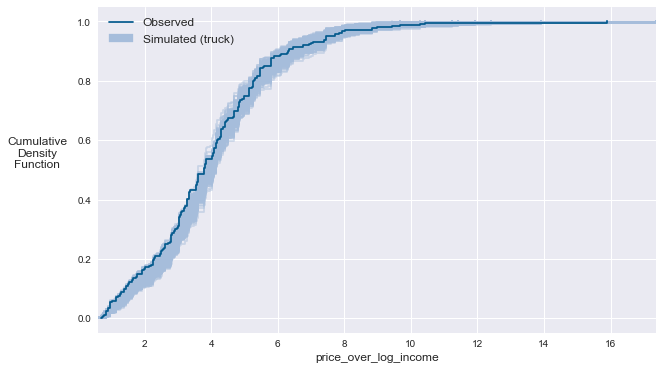

In [19]:
for body in ['regcar', 'sportcar', 'stwagon', 'van', 'truck']:
    current_body = body
    filter_row = car_df.body_type == current_body
    # current_title =\
    #     'CDF of Price/log(income) for Sport Utility Vehicles'
    current_title = ''
    filename = None
    viz.plot_simulated_cdf_traces(likelihood_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  label='Simulated ({})'.format(body),
                                  title=current_title,
                                  figsize=(10, 6),
                                  output_file=filename)

In [ ]:
for body in ['regcar', 'sportcar', 'stwagon', 'van', 'truck']:
    filter_idx = (car_df.body_type == body).values
    current_probs = long_fitted_probs[filter_idx]
    current_choices = mnl.choices[filter_idx]
    current_sim_y = likelihood_sim_y[filter_idx, :]
    current_line_label = 'Observed vs Predicted ({})'.format(body)
    current_sim_label = 'Simulated vs Predicted ({})'.format(body)

    current_sim_color = '#a6bddb'
    current_obs_color = '#045a8d'

    reliability_path = None
    viz.plot_binned_reliability(
        current_probs,
        current_choices,
        sim_y=current_sim_y,
        line_label=current_line_label,
        line_color=current_obs_color,
        sim_label=current_sim_label,
        sim_line_color=current_sim_color,
        figsize=(10, 6),
        ref_line=True,
        output_file=reliability_path)

In [ ]:
for fuel in ['cng', 'electric', 'gasoline']:
    current_fuel = fuel
    filter_idx = np.where((car_df.fuel_type == current_fuel).values)[0]
    current_probs = long_fitted_probs[filter_idx]
    current_choices = mnl.choices[filter_idx]
    current_sim_y = likelihood_sim_y[filter_idx, :]
    current_line_label = 'Observed vs Predicted ({})'.format(current_fuel)
    current_sim_label = 'Simulated vs Predicted ({})'.format(current_fuel)

    current_sim_color = '#a6bddb'
    current_obs_color = '#045a8d'

    reliability_path = None
    viz.plot_binned_reliability(
        current_probs,
        current_choices,
        sim_y=current_sim_y,
        line_label=current_line_label,
        line_color=current_obs_color,
        sim_label=current_sim_label,
        sim_line_color=current_sim_color,
        figsize=(10, 6),
        ref_line=True,
        output_file=reliability_path)